In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import PaSDqc

In [2]:
sns.set_context("poster")
sns.set_style("ticks", {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})

## 1465 sample data

In [3]:
# number of observations on 3p arm
n_obs = 1017399

In [4]:
f_norm = PaSDqc.extra_tools.get_data_file("bulk_1x.smooth3.spec")
norm = pd.Series.from_csv(f_norm, sep="\t").as_matrix()

In [5]:
psd_MDA_30 = PaSDqc.PSDTools.SamplePSD(pd.read_table("../data/Lodato_2015/1465/psd/1465-cortex_1-neuron_MDA_30.1x.chroms.spec"), name="MDA_30")
psd_30_avg = psd_MDA_30.avg_PSD()

## Normal Distribution

### Simulate a linear amplification process for chr3p

In [6]:
start = 0
end = 90504854
mu = 4.22556395
sigma = 0.42266751

rd, psd_erf = PaSDqc.simulate.simulate(PaSDqc.simulate.simulate_erf_profile, start, end+100000, 
                                       n_obs, mu, sigma, depth=1)

Simulating read depth
Performing PSD analysis


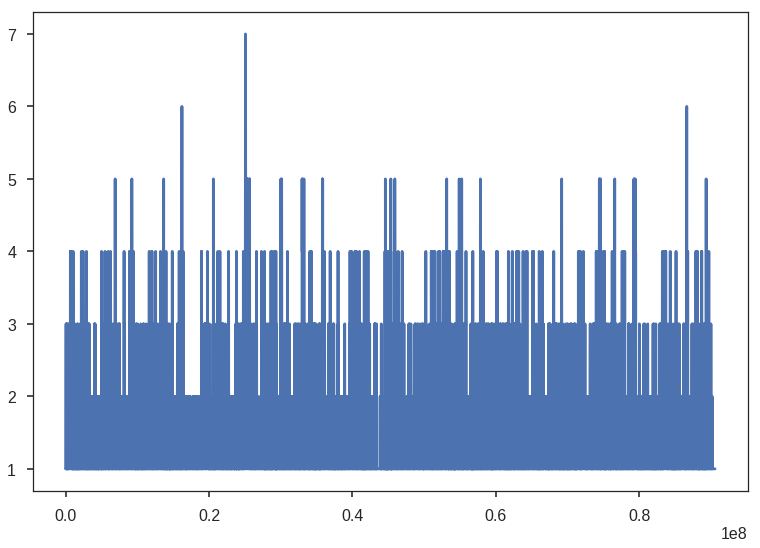

In [7]:
plt.plot(rd.pos, rd.depth)

### Power Spectral Density

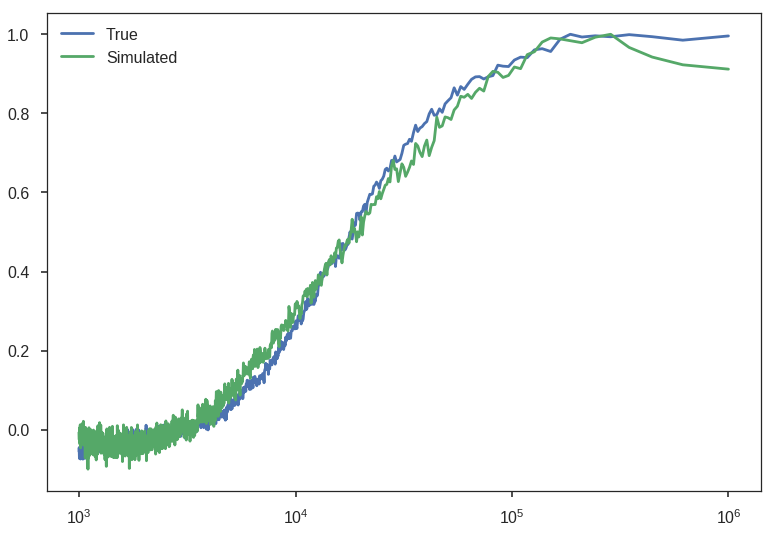

In [10]:
freq = psd_MDA_30.df.freq
freq_cut = freq[freq < 1e-3]
psd_norm_cut = psd_erf[freq < 1e-3]
psd_30_cut = psd_30_avg[freq < 1e-3]
norm_cut = norm[freq<1e-3]

plt.plot(1/freq_cut, (10*np.log10(psd_30_cut/norm_cut)-4) / np.max(10*np.log10(psd_30_cut/norm_cut)-4), label="True")
plt.plot(1/freq_cut, 10*np.log10(psd_norm_cut/norm_cut)/np.max(10*np.log10(psd_norm_cut/norm_cut)), label='Simulated')
plt.xscale('log')
plt.legend(loc='upper left')

## Logistic Simulation

### Simulate a linear amplification process for chr3p

In [11]:
start = 0
end = 90504854
mu = 4.21952877
sigma = 0.25647079

rd, psd_logis = PaSDqc.simulate.simulate(PaSDqc.simulate.simulate_logis_profile, start, end+100000, 
                                         n_obs, mu, sigma, depth=1)

Simulating read depth
Performing PSD analysis


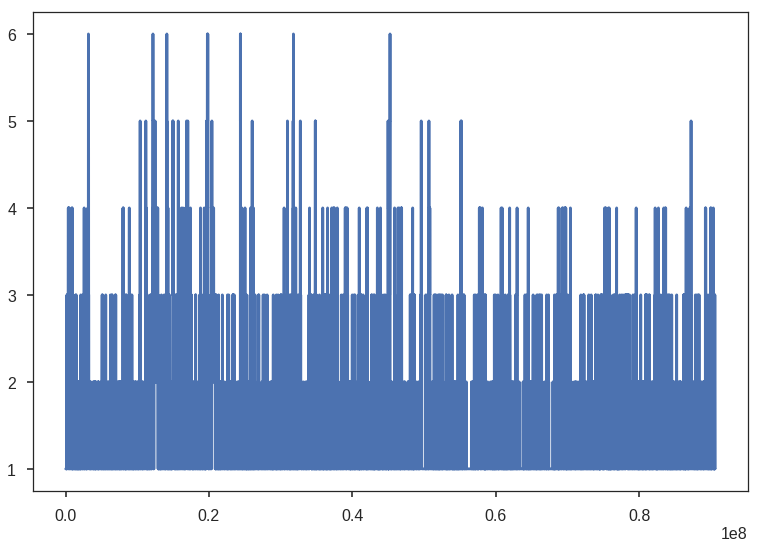

In [12]:
plt.plot(rd.pos, rd.depth)

### Comparison to 1465 MDA 30

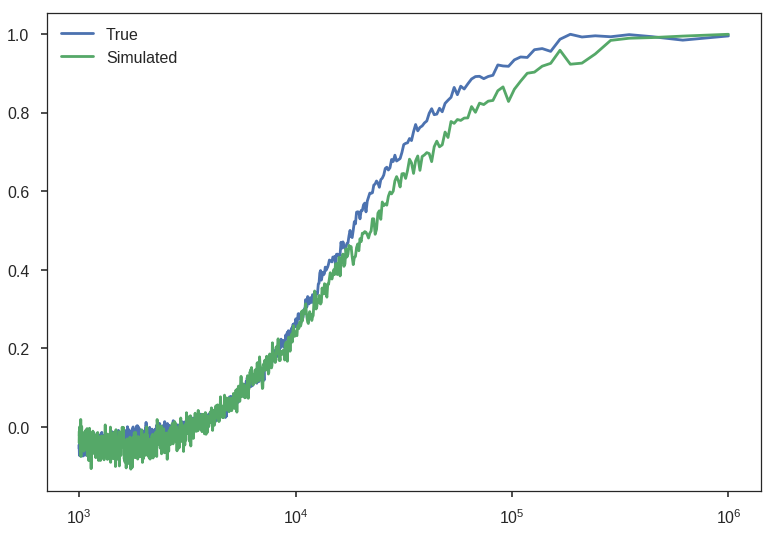

In [13]:
freq = psd_MDA_30.df.freq
freq_cut = freq[freq < 1e-3]
psd_logis_cut = psd_logis[freq < 1e-3]
psd_30_cut = psd_30_avg[freq < 1e-3]
norm_cut = norm[freq<1e-3]

plt.plot(1/freq_cut, (10*np.log10(psd_30_cut/norm_cut)-4) / np.max(10*np.log10(psd_30_cut/norm_cut)-4), label='True')
plt.plot(1/freq_cut, 10*np.log10(psd_logis_cut/norm_cut)/np.max(10*np.log10(psd_logis_cut/norm_cut)), label='Simulated')
plt.xscale('log')
plt.legend()

## Gamma Distribution

### Simulate a linear amplification process for chr3p

In [18]:
start = 0
end = 90504854
alpha = 6.91199253
beta = 5.22447037

rd = PaSDqc.simulate.simulate_gamma_profile(start, end+100000, alpha, beta, depth=1)
rd_s = pd.DataFrame(rd[:end], columns=['depth'])
rd_uniq = rd_s[rd_s.depth>0].sample(n=n_obs, replace=False).sort_index()
rd_uniq['pos'] = rd_uniq.index

pwr, count = PaSDqc.PSDTools.ChromPSD.PSD_LS_manual(rd_uniq, freq, l_seg=1e6)
psd_gamma = pwr / count

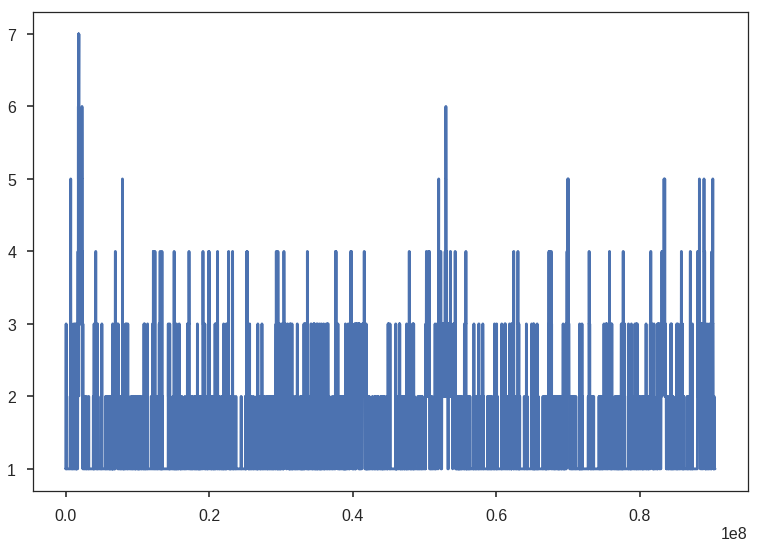

In [19]:
plt.plot(rd_uniq.pos, rd_uniq.depth)

### Power Spectral Density

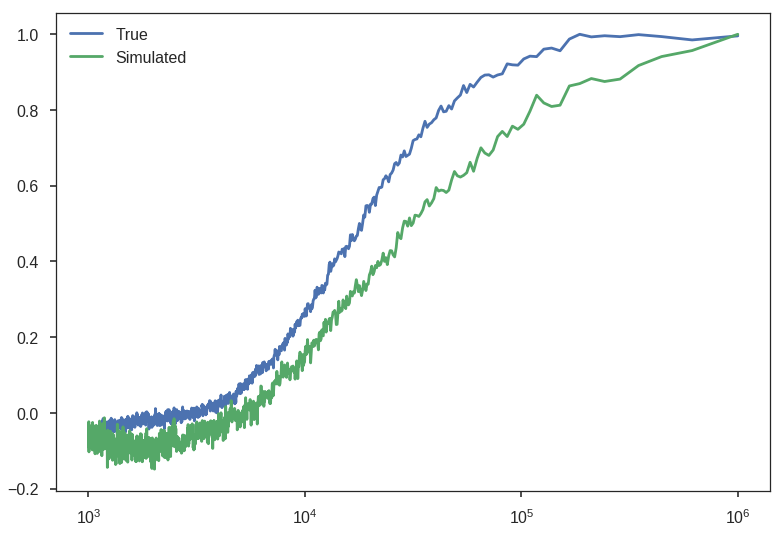

In [21]:
freq_cut = freq[freq < 1e-3]
psd_gamma_cut = psd_gamma[freq < 1e-3]
psd_30_cut = psd_30_avg[freq < 1e-3]
norm_cut = norm[freq<1e-3]

plt.plot(1/freq_cut, (10*np.log10(psd_30_cut/norm_cut)-4) / np.max(10*np.log10(psd_30_cut/norm_cut)-4), label="True")
plt.plot(1/freq_cut, 10*np.log10(psd_gamma_cut/norm_cut)/np.max(10*np.log10(psd_gamma_cut/norm_cut)), label="Simulated")
plt.legend()
plt.xscale('log')

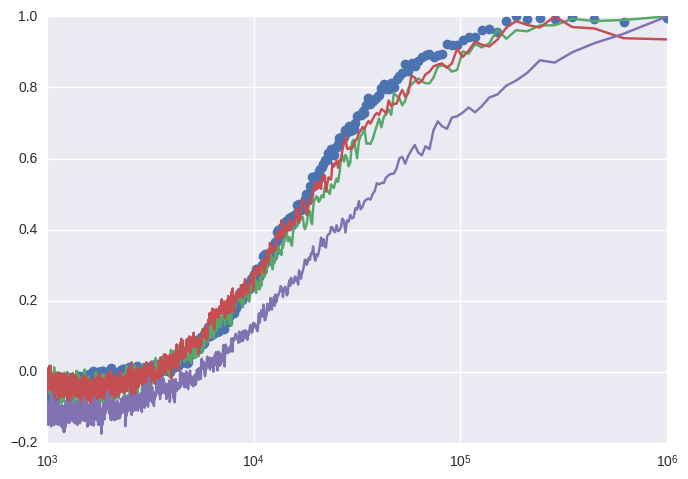

In [41]:
psd_mda_30_normed = (10*np.log10(psd_30_cut/norm_cut)-4) / np.max(10*np.log10(psd_30_cut/norm_cut)-4)
psd_gamma_normed = 10*np.log10(psd_gamma_cut)/np.max(10*np.log10(psd_gamma_cut))
psd_erf_normed = 10*np.log10(psd_norm_cut/norm_cut)/np.max(10*np.log10(psd_norm_cut/norm_cut))
psd_logis_normed = 10*np.log10(psd_logis_cut/norm_cut)/np.max(10*np.log10(psd_logis_cut/norm_cut))

plt.plot(1/freq_cut, psd_mda_30_normed, 'o')
plt.plot(1/freq_cut, psd_logis_normed)
plt.plot(1/freq_cut, psd_erf_normed)
plt.plot(1/freq_cut, psd_gamma_normed)
# plt.plot(1/freq)
plt.xscale('log')

## Let's do it a bunch of Times

In [23]:
def sim_erf(start, end, mu, sigma, n_obs):
    rd = PaSDqc.simulate.simulate_erf_profile(start, end+100000, mu, sigma, depth=1)
    rd_s = pd.DataFrame(rd[:end], columns=['depth'])
    rd_uniq = rd_s[rd_s.depth>0].sample(n=n_obs, replace=False).sort_index()
    rd_uniq['pos'] = rd_uniq.index

    pwr, count = PaSDqc.PSDTools.ChromPSD.PSD_LS_manual(rd_uniq, freq, l_seg=1e6)
    psd_gamma = pwr / count
    
    return psd_gamma

In [24]:
def sim_logis(start, end, mu, sigma, n_obs):
    rd = PaSDqc.simulate.simulate_logis_profile(start, end+100000, mu, sigma, depth=1)
    rd_s = pd.DataFrame(rd[:end], columns=['depth'])
    rd_uniq = rd_s[rd_s.depth>0].sample(n=n_obs, replace=False).sort_index()
    rd_uniq['pos'] = rd_uniq.index

    pwr, count = PaSDqc.PSDTools.ChromPSD.PSD_LS_manual(rd_uniq, freq, l_seg=1e6)
    psd_gamma = pwr / count
    
    return psd_gamma

In [25]:
def sim_gamma(start, end, alpha, beta, n_obs):
    rd = PaSDqc.simulate.simulate_gamma_profile(start, end+100000, alpha, beta, depth=1)
    rd_s = pd.DataFrame(rd[:end], columns=['depth'])
    rd_uniq = rd_s[rd_s.depth>0].sample(n=n_obs, replace=False).sort_index()
    rd_uniq['pos'] = rd_uniq.index

    pwr, count = PaSDqc.PSDTools.ChromPSD.PSD_LS_manual(rd_uniq, freq, l_seg=1e6)
    psd_gamma = pwr / count
    
    return psd_gamma

In [11]:
def normalize(freq, psd, norm, shift=0):
    freq_cut = freq[freq < 1e-3]
    psd_cut = psd[freq < 1e-3]
    norm_cut = norm[freq < 1e-3]
    normed = 10*np.log10(psd_cut/norm_cut) + shift
    
    return normed/np.max(normed)

### MDA

In [9]:
start = 0
end = 90504854
mu =  4.22556329
sigma = 0.42266653

freq = np.linspace(1e-6, 5e-3, 8000)
psd_erf_list = []

for i in range(10):
    print(i)
    psd_erf = sim_erf(start, end, mu, sigma)
    psd_erf_list.append(psd_erf)

0
1
2
3
4
5
6
7
8
9


In [9]:
start = 0
end = 90504854
mu = 4.21952877
sigma = 0.25647079

freq = np.linspace(1e-6, 5e-3, 8000)
psd_logis_list = []

for i in range(10):
    print(i)
    psd_logis = sim_logis(start, end, mu, sigma)
    psd_logis_list.append(psd_logis)

0
1
2
3
4
5
6
7
8
9


In [19]:
start = 0
end = 90504854
alpha = 6.91199253
beta = 5.22447037

freq = np.linspace(1e-6, 5e-3, 8000)
psd_gamma_list = []

for i in range(10):
    print(i)
    psd_gamma = sim_gamma(start, end, alpha, beta)
    psd_gamma_list.append(psd_gamma)

0
1
2
3
4
5
6
7
8
9


In [12]:
psd_erf_list_normed = [normalize(freq, psd, norm) for psd in psd_erf_list]
nd_erf_sims = np.array(psd_erf_list_normed)
erf_avg = np.mean(nd_erf_sims, axis=0)
erf_se = np.std(nd_erf_sims, axis=0)
df_sim = pd.DataFrame({'avg': erf_avg, "se": erf_se})

In [14]:
psd_logis_list_normed = [normalize(freq, psd, norm) for psd in psd_logis_list]
nd_logis_sims = np.array(psd_logis_list_normed)
logis_avg = np.mean(nd_logis_sims, axis=0)
logis_se = np.std(nd_logis_sims, axis=0)
df_logis = pd.DataFrame({'avg': logis_avg, "se": logis_se})

In [20]:
psd_gamma_list_normed = [normalize(freq, psd, norm) for psd in psd_gamma_list]
nd_gamma_sims = np.array(psd_gamma_list_normed)
gamma_avg = np.mean(nd_gamma_sims, axis=0)
gamma_se = np.std(nd_gamma_sims, axis=0)
df_gamma = pd.DataFrame({'avg': gamma_avg, "se": gamma_se})

In [14]:
df_sim.to_csv("1465_MDA_30_erf_sim.txt", sep="\t", index=False, header=True)

In [16]:
df_logis.to_csv("1465_MDA_30_logis_sim.txt", sep="\t", index=False, header=True)

In [22]:
df_gamma.to_csv("1465_MDA_30_gamma_sim.txt", sep="\t", index=False, header=True)

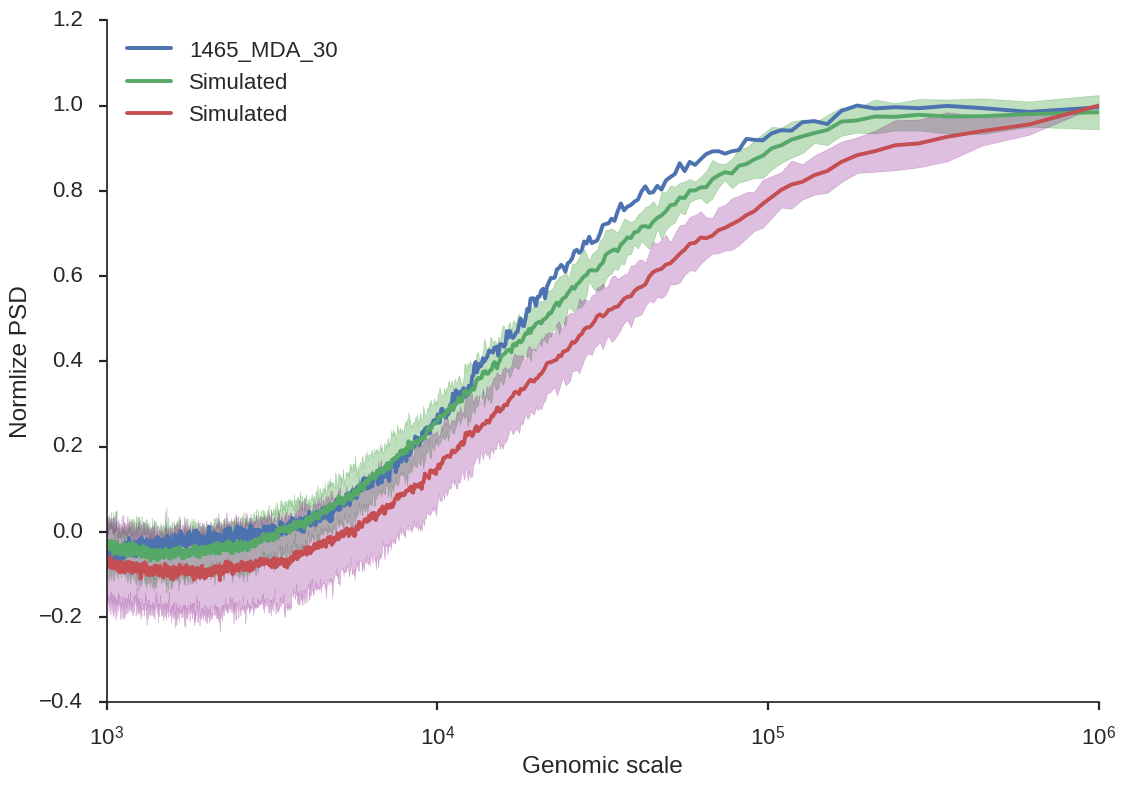

In [21]:
freq_cut = freq[freq < 1e-3]
psd_30 = normalize(freq, psd_30_avg, norm, shift=-4)
# erf_avg_cut = erf_avg[freq<1e-3]
# erf_se_cut = erf_se[freq<1e-3]

plt.plot(1/freq_cut, psd_30, label='1465_MDA_30')
plt.plot(1/freq_cut, logis_avg, label='Simulated')
plt.fill_between(1/freq_cut, logis_avg-2*logis_se, logis_avg+2*logis_se, alpha=0.25, color='green')
plt.plot(1/freq_cut, gamma_avg, label='Simulated')
plt.fill_between(1/freq_cut, gamma_avg-2*gamma_se, gamma_avg+2*gamma_se, alpha=0.25, color='purple')
# plt.plot(1/freq_cut, erf_avg, label='Simulated')
# plt.fill_between(1/freq_cut, erf_avg-2*erf_se, erf_avg+2*erf_se, alpha=0.25, color='green')

plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('Normlize PSD')
plt.xlabel('Genomic scale')
sns.despine()

### MALBAC

In [28]:
psd_malbac = PSDTools.SamplePSD(pd.read_table("/home/mas138/orchestra/data/BSM/Cell/MALBAC/MDAqc/1x/psd/MALBAC_single-cell_SRX204745.sorted.1x.chroms.spec"), name="MDA_30")
psd_mal_avg = psd_malbac.avg_PSD()

In [26]:
start = 0
end = 90504854
mu =   3.39868161
sigma = 0.2091362
n_obs = 1017399

freq = np.linspace(1e-6, 5e-3, 8000)
psd_erf_list = []

for i in range(10):
    print(i)
    psd_erf = sim_erf(start, end, mu, sigma, n_obs)
    psd_erf_list.append(psd_erf)

0
1
2
3
4
5
6
7
8
9


In [34]:
start = 0
end = 90504854
mu =  3.39315261 
sigma = 0.13124728
n_obs = 1017399

freq = np.linspace(1e-6, 5e-3, 8000)
psd_logis_list = []

for i in range(10):
    print(i)
    psd_logis = sim_logis(start, end, mu, sigma, n_obs)
    psd_logis_list.append(psd_logis)

0
1
2
3
4
5
6
7
8
9


In [38]:
start = 0
end = 90504854
alpha = 4.21507332
beta = 9.50393038

freq = np.linspace(1e-6, 5e-3, 8000)
psd_gamma_list = []

for i in range(10):
    print(i)
    psd_gamma = sim_gamma(start, end, alpha, beta, n_obs)
    psd_gamma_list.append(psd_gamma)

0
1
2
3
4
5
6
7
8
9


In [27]:
psd_erf_list_normed = [normalize(freq, psd, norm) for psd in psd_erf_list]
nd_erf_sims = np.array(psd_erf_list_normed)
erf_avg = np.mean(nd_erf_sims, axis=0)
erf_se = np.std(nd_erf_sims, axis=0)
df_sim = pd.DataFrame({'avg': erf_avg, "se": erf_se})

In [35]:
psd_logis_list_normed = [normalize(freq, psd, norm) for psd in psd_logis_list]
nd_logis_sims = np.array(psd_logis_list_normed)
logis_avg = np.mean(nd_logis_sims, axis=0)
logis_se = np.std(nd_logis_sims, axis=0)
df_logis = pd.DataFrame({'avg': logis_avg, "se": logis_se})

In [39]:
psd_gamma_list_normed = [normalize(freq, psd, norm) for psd in psd_gamma_list]
nd_gamma_sims = np.array(psd_gamma_list_normed)
gamma_avg = np.mean(nd_gamma_sims, axis=0)
gamma_se = np.std(nd_gamma_sims, axis=0)
df_gamma = pd.DataFrame({'avg': gamma_avg, "se": gamma_se})

In [32]:
df_sim.to_csv("MALBAC_erf_sim.txt", sep="\t", index=False, header=True)

In [37]:
df_logis.to_csv("MALBAC_logis_sim.txt", sep="\t", index=False, header=True)

In [41]:
df_gamma.to_csv("MALBAC_gamma_sim.txt", sep="\t", index=False, header=True)

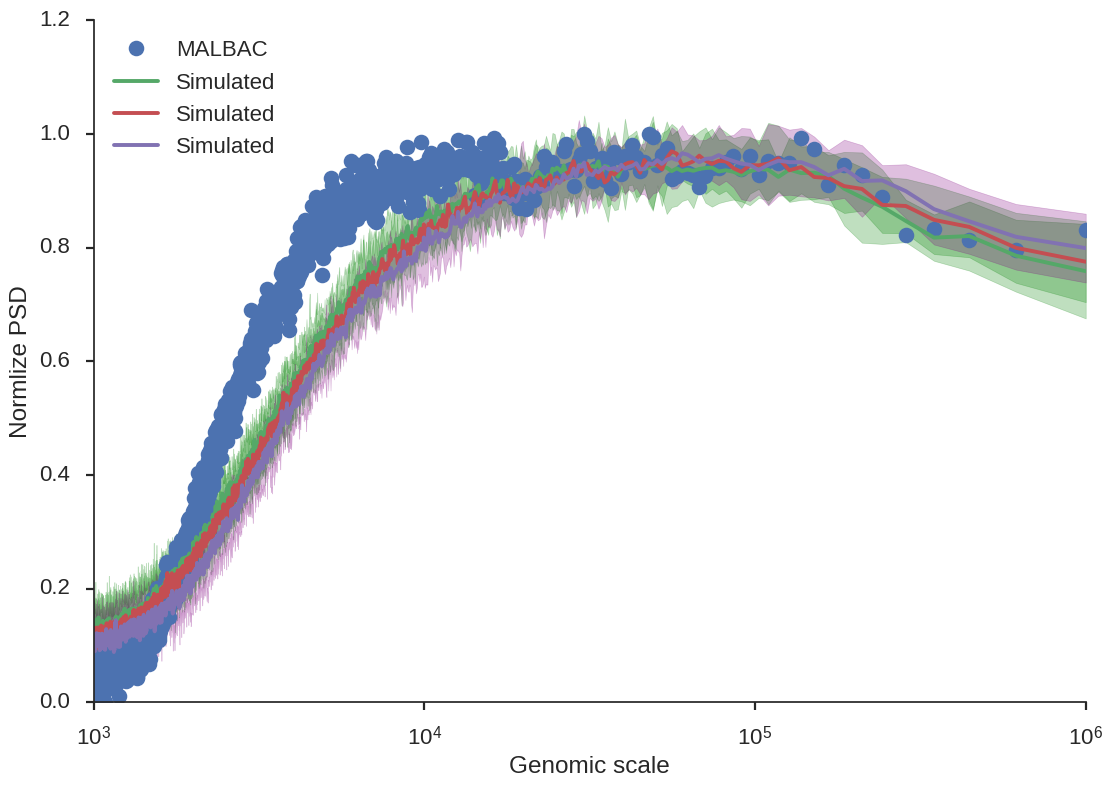

In [40]:
freq_cut = freq[freq < 1e-3]
psd_mal = normalize(freq, psd_mal_avg, norm, shift=-7)
# erf_avg_cut = erf_avg[freq<1e-3]
# erf_se_cut = erf_se[freq<1e-3]

plt.plot(1/freq_cut, psd_mal, 'o', label='MALBAC')
plt.plot(1/freq_cut, erf_avg, label='Simulated')
plt.fill_between(1/freq_cut, erf_avg-2*erf_se, erf_avg+2*erf_se, alpha=0.25, color='green')
plt.plot(1/freq_cut, logis_avg, label='Simulated')
plt.fill_between(1/freq_cut, logis_avg-2*logis_se, logis_avg+2*logis_se, alpha=0.25, color='green')
plt.plot(1/freq_cut, gamma_avg, label='Simulated')
plt.fill_between(1/freq_cut, gamma_avg-2*gamma_se, gamma_avg+2*gamma_se, alpha=0.25, color='purple')


plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('Normlize PSD')
plt.xlabel('Genomic scale')
sns.despine()